In [1]:
using Polynomials
push!(LOAD_PATH, pwd())
using Controlz
using Test
using DifferentialEquations
using Logging
using DataFrames
using LaTeXStrings
using PyPlot
PyPlot.matplotlib.style.use(normpath(joinpath(pathof(Controlz), "..", "hipster.mplstyle")))

┌ Info: Precompiling Controlz [e034abe6-471a-4d54-96dd-ecd1f4022419]
└ @ Base loading.jl:1273


In [2]:
τ = 3.45
g = 1 / (τ * s + 1) # FO system
t, y = simulate(g / s, 10.0) # unit step response
y_at_τ = interpolate(t, y, τ) # 0.63

0.6320802858882434

## First order plus time delay, response to step

$g(s)=\dfrac{Ke^{-\theta s}}{\tau s + 1}$

response to step input $U(s)=1/s$.

In [3]:
K = 2.0 # gain
τ = 4.0 # time constant
θ = 1.5 # time delay
g = K * exp(-θ * s) / (τ * s + 1) # FOPTD transfer function


    2.0
----------- e^(-1.5*s)
4.0*s + 1.0

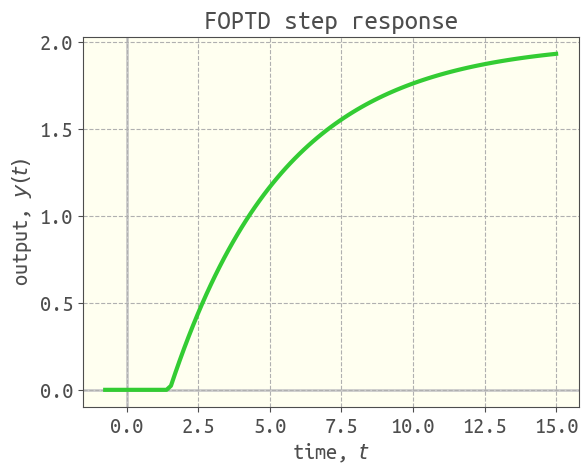

In [4]:
U = 1 / s # step input
Y = g * U

t, y = simulate(Y, 15.0)

viz_response(t, y, plot_title="FOPTD step response")
savefig("../docs/src/FOPTD_step_response.png", format="png")

## Second order underdamped, response to step

$g(s)=\dfrac{4}{4 s ^2 + 0.8 s + 1}$

response to step input $U(s)=1/s$.

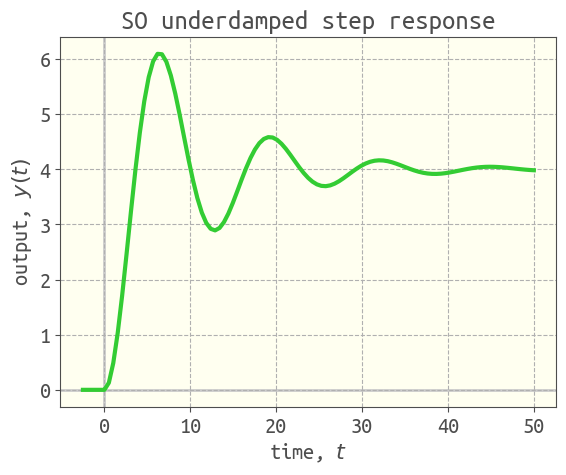

In [5]:
g = 4 / (4 * s ^ 2 + 0.8 * s + 1)
U = 1 / s
Y = g * U
t, y = simulate(Y, 50.0)

viz_response(t, y, plot_title="SO underdamped step response")
savefig("../docs/src/SO_underdamped_step_response.png", format="png")

## inverting an input

$\mathcal{L}[t \cos(at)]= \dfrac{s^2-a^2}{(s^2+a^2)^2}$

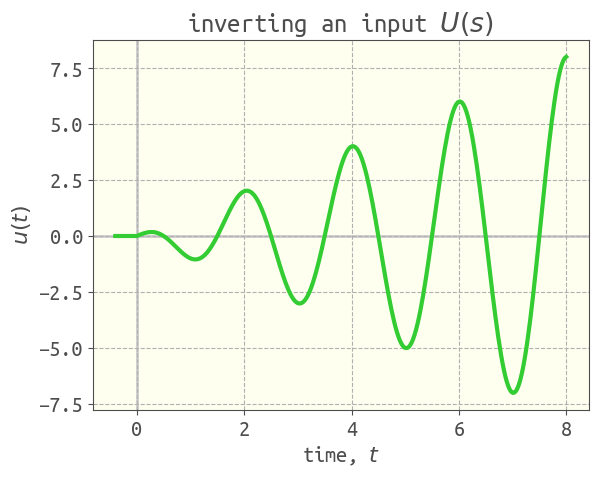

In [6]:
a = π
U = (s^2 - a^2) / (s^2 + a^2) ^ 2
t, u = simulate(U, 8.0, nb_time_points=300)

viz_response(t, u, plot_title=L"inverting an input $U(s)$", plot_ylabel=L"$u(t)$")
savefig("../docs/src/tcosat.png", format="png")

## servo response of a control system

![](simple_servo.png)

gc = 
1.0*s + 1.0
-----------
   1.0*s

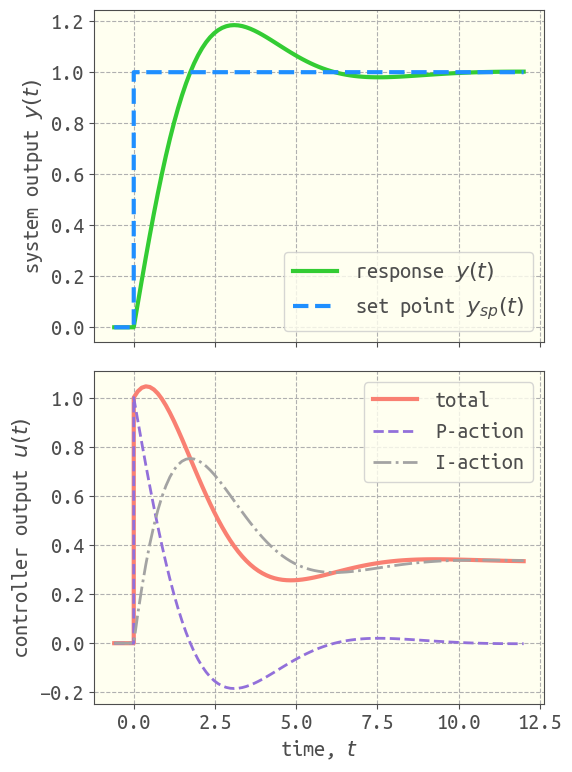


gp = 
    3.0
-----------
4.0*s + 1.0
Y_sp = 
  1
-----
1.0*s


In [11]:
Kc = 1.0
τI = 1.0
pic = PIController(1.0, 1.0) 
gc = TransferFunction(pic) # controller transfer functio
@show gc

gp = 3 / (4 * s + 1) # process transfer function
@show gp

g_ol = gc * gp # open-loop transfer function

g_servo = g_ol / (1 + g_ol) # transfer function for servo response

Y_sp = 1 / s # unit step set point change
@show Y_sp

Y = g_servo * Y_sp # resulting output

E = Y_sp - Y # error signal

U = gc * E # resulting controller output

# break output into P-action, I-action
U_Paction = Kc * E
U_Iaction = Kc * τI / s * E

# simulate for y, u, ysp in the time domain
final_time = 12.0
t, y = simulate(Y, final_time)
t, u = simulate(U, final_time)
t, ysp = simulate(Y_sp, final_time)
t, u_Paction = simulate(U_Paction, final_time)
t, u_Iaction = simulate(U_Iaction, final_time)

fig, ax = subplots(2, 1, sharex=true, figsize=(6, 8))
xlabel(L"time, $t$")

ax[1].plot(t, y, label=L"response $y(t)$")
ax[1].plot(t, ysp, linestyle="--", label=L"set point $y_{sp}(t)$")
ax[1].legend()
ax[1].set_ylabel(L"system output $y(t)$")

ax[2].plot(t, u, color="C2", label="total")
ax[2].plot(t, u_Paction, color="C3", linestyle="--", label="P-action", lw=2)
ax[2].plot(t, u_Iaction, color="C4", linestyle="-.", label="I-action", lw=2)
ax[2].legend()
ax[2].set_ylabel(L"controller output $u(t)$")
tight_layout()

savefig("../docs/src/simple_servo_response.png", format="png")

## a full feedback control system

![](full_feedback_control_system.png)

## viz poles and zeros of a transfer function

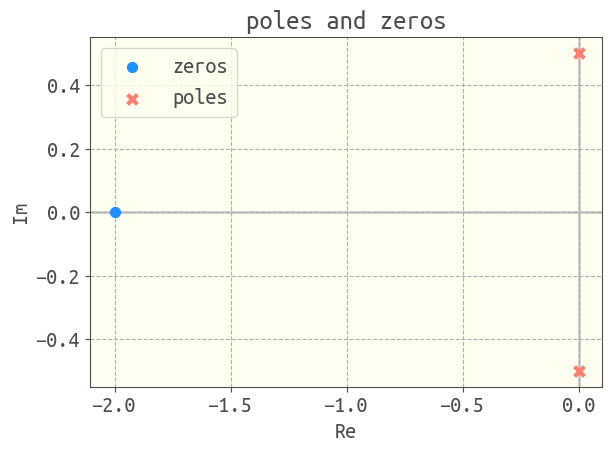

In [12]:
g = (s + 2) / (s^2 + 1/4)
viz_poles_and_zeros(g)
savefig("../docs/src/example_poles_and_zeros.png", format="png")

## Nyquist diagram

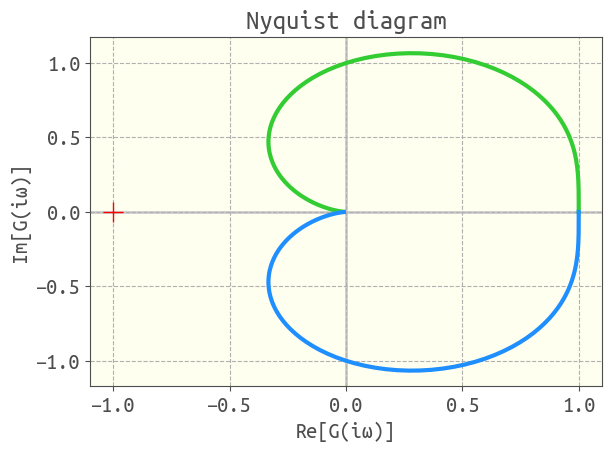

In [13]:
g = 1 / (s^2 + s + 1) # https://en.wikipedia.org/wiki/Nyquist_stability_criterion
nyquist_diagram(g)
savefig("../docs/src/example_nyquist.png", format="png")

## root locus diagram

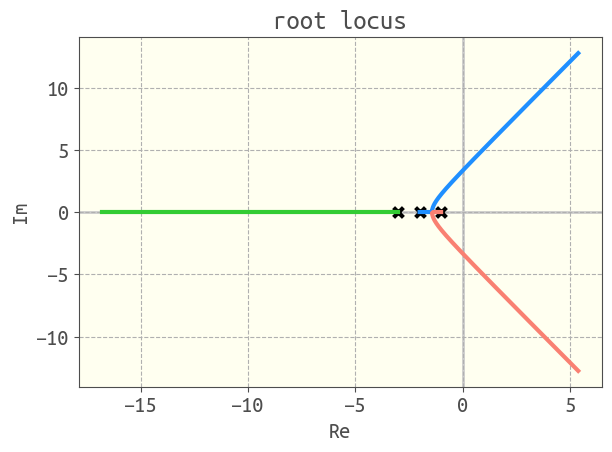

In [14]:
g_ol = 4 / (s + 3) / (s + 2) / (s + 1)

root_locus(g_ol)
savefig("../docs/src/example_root_locus.png", format="png")

## Bode plot

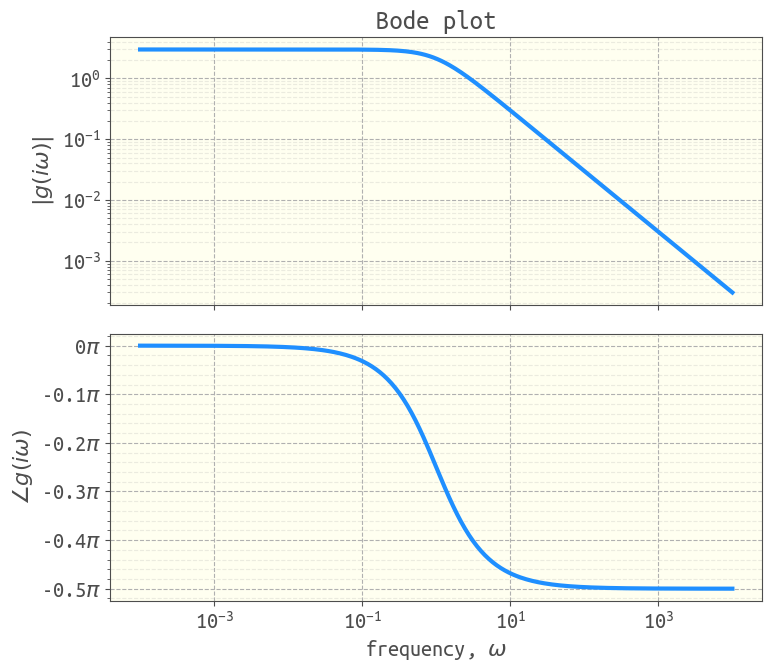

In [15]:
g = 3 / (s+1)

bode_plot(g)
savefig("../docs/src/example_bode.png", format="png")

gain and phase margins, critical frequency, gain crossover frequency

In [16]:
margins = gain_phase_margins(g)

-- gain/phase margin info--
	critical frequency ω_c [rad/time]:       NaN
	gain crossover frequency ω_g [rad/time]: 2.82843
	gain margin:                             NaN
	phase margin:                            1.91063


In [17]:
# TODO rectangular pulse
M = 3.2
θ = 2.03
U = M / s * (1 - exp(-θ * s))
t, u = simulate(U, 12.0)
rec_pulse(t::Float64) = ((t < 0.0) || (t > θ)) ? 0.0 : M
@test isapprox(u, _rec_pulse.(t), rtol=0.001)

ErrorException: cannot add two transfer functions that have different time delays